In [154]:
# !pip install backtrader
# !pip install yfinance --upgrade --no-cache-dir
# !pip install ipympl
# !pip install ipywidgets

In [155]:
import datetime
from model import volatility
from model import trading_intensity
from model import AvellanedaStoikov
import pandas as pd
import numpy as np
orderbook_df = pd.read_csv ('historical_ETHUSDT_orderbook_data.csv')
kline_full_df = pd.read_csv('historical_ETHUSDT_kline_data.csv')

kline_next_df = kline_full_df.copy()
kline_next_df['Datetime'] = kline_next_df['Datetime'].apply(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000) )    

kline_reduced_array = []

for datetime in np.unique( kline_full_df['Datetime'].tolist() ):
    kline_reduced_array.append( kline_next_df[kline_full_df['Datetime'] == datetime].tail(1) )

kline_next_df = pd.concat(kline_reduced_array, axis=0)

kline_next_df.set_index('Datetime', inplace=True)

kline_next_df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-03-14 22:34:00,3817.55,3820.92,3812.30,3813.74,5514.190
2024-03-14 22:35:00,3813.77,3817.54,3811.82,3812.16,4410.927
2024-03-14 22:36:00,3812.15,3814.04,3801.00,3801.31,6366.543
2024-03-14 22:37:00,3801.31,3810.11,3793.16,3793.34,14473.478
2024-03-14 22:38:00,3793.34,3807.30,3791.92,3799.52,8095.484


In [156]:
kline_full_df.head()

,Datetime,Open,High,Low,Close,Volume
0,1710470040000,3817.55,3820.92,3813.48,3816.80,4548.518
1,1710470040000,3817.55,3820.92,3813.48,3816.78,4560.994
2,1710470040000,3817.55,3820.92,3813.48,3816.32,4565.007
3,1710470040000,3817.55,3820.92,3813.48,3815.68,4586.762
4,1710470040000,3817.55,3820.92,3813.48,3815.28,4607.774


In [157]:
orderbook_df.head()

,Datetime,bidp0,bidp1,bidp2,bidp3,bidp4,bidp5,bidp6,bidp7,bidp8,...,askv0,askv1,askv2,askv3,askv4,askv5,askv6,askv7,askv8,askv9
0,1710470077221,3816.8,3816.79,3816.78,3816.76,3816.72,3816.70,3816.68,3816.67,3816.64,...,2.622,0.032,0.007,0.052,0.007,0.019,2.962,6.000,0.006,0.007
1,1710470077337,3816.8,3816.79,3816.78,3816.76,3816.75,3816.74,3816.72,3816.70,3816.68,...,2.769,0.006,0.007,0.052,0.007,0.019,2.962,6.000,0.006,0.007
2,1710470077476,3816.8,3816.79,3816.78,3816.76,3816.75,3816.72,3816.68,3816.67,3816.64,...,6.551,0.006,0.007,0.052,0.007,4.116,0.019,2.962,6.000,0.524
3,1710470077584,3816.8,3816.79,3816.78,3816.76,3816.72,3816.68,3816.65,3816.64,3816.63,...,26.965,0.006,0.052,0.262,0.007,0.187,0.524,0.007,5.348,0.019
4,1710470077711,3816.8,3816.79,3816.78,3816.76,3816.72,3816.68,3816.65,3816.64,3816.62,...,6.844,0.006,0.052,0.262,0.007,0.187,0.524,0.007,4.116,0.019


In [158]:
for i in range(3):
    k = trading_intensity(orderbook_df , 1710470100000 + i * 60000)
    
    as1 = AvellanedaStoikov(3816.80, 50, sigma, gamma, k * 100 , eta , 1 , 0.001)

    print( k , as1.reservation_price() , as1.optimal_bid_ask_spread() , as1.optimal_bid() , as1.optimal_ask() ,
         as1.bid_size(50 , 10000) , as1.ask_size(50 , 10000) )

0.0019955375879590013 3815.9624240497237 8.14095609729417 3811.8919460010766 3820.032902098371 2.0430820025956344 2.6177784998937916
0.007125760741546995 3815.9624240497237 2.6432087662677413 3814.64081966659 3817.2840284328577 2.04160973441131 2.619663594722184
-0.032894310355561285 3815.9624240497237 -0.6006898844309905 3816.262768991939 3815.6620791075084 2.0407420301331194 2.6207771528706814


In [159]:
k = trading_intensity(orderbook_df , 1710470100000	)

k

0.0019955375879590013

In [160]:
# https://blog.quantinsti.com/backtrader/
import datetime
import backtrader as bt
import yfinance as yf

from backtrader import Order

def str_to_timestamp( s ):
    return int( datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timestamp() * 1000 )

orderbook_timestamp = orderbook_df['Datetime'].tolist()

def smallest_timestamp_before( t ):
    for i in range(len(orderbook_timestamp)):
        if orderbook_timestamp[i] > t:
            return int(orderbook_timestamp[i-1])

def time_percentage( t ):
    start_time = kline_full_df.iloc[1]['Datetime']
    end_time = kline_full_df.iloc[-1]['Datetime']
    time_diff = end_time - start_time
    return (t - start_time ) /(end_time - start_time)

class MAstrategy(bt.Strategy):
	# when initializing the instance, create a 100-day MA indicator using the closing price
    def __init__(self):
        #self.ma = bt.indicators.SimpleMovingAverage(self.data.close, period=2)
        self.orders = []
        
        #print( str_to_timestamp( str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )   ) 

    def next(self):
        time = str_to_timestamp( str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )   )  

        if kline_full_df.iloc[1]['Datetime'] >= time:
            return
        
        ask_price_at_time = orderbook_df[orderbook_df["Datetime"] == smallest_timestamp_before(  time	)].iloc[0] ['askp0']
        bid_price_at_time = orderbook_df[orderbook_df["Datetime"] == smallest_timestamp_before(  time	)].iloc[0] ['bidp0']
        
        s = 0.5 * ( ask_price_at_time + bid_price_at_time )

        sigma = volatility(kline_full_df , time)

        k = trading_intensity(orderbook_df , time)

        eta = 0.005
        
        gamma = 0.1

        qt = self.position.size
        
        AS = AvellanedaStoikov(s, qt, sigma, gamma, k * 100 , eta , 1 , time_percentage(time) )
        
        #print(self.position.size)
        #print(self.stats.broker.cash[0] , self.stats.broker.value[0])

        #print( s , AS.optimal_bid() , AS.optimal_ask() )

        if k > 0 :
            for order in self.orders:
                self.broker.cancel(order)
            self.log('Buy Limit Create, %.2f' % AS.optimal_bid())
            order = self.buy(exectype=Order.Limit, price=AS.optimal_bid() , size=AS.bid_size(qt , self.stats.broker.value[0] * 0.5) )
            self.log('Sell Limit Create, %.2f' % AS.optimal_ask())
            order = self.sell(exectype=Order.Limit, price=AS.optimal_ask() , size=AS.bid_size(qt , self.stats.broker.value[0] * 0.5) )
        
        '''
        if self.order:
            return
        if not self.position: # check if you already have a position in the market
            if (self.data.close[0] > self.ma[0]) & (self.data.close[-1] < self.ma[-1]):
                self.log('Buy Create, %.2f' % self.data.close[0])
                self.order = self.buy(size=0) # buy when closing price today crosses above MA.
            if (self.data.close[0] < self.ma[0]) & (self.data.close[-1] > self.ma[-1]):
                self.log('Sell Create, %.2f' % self.data.close[0])
                self.order = self.sell(size=1)  # sell when closing price today below MA
        else:
        # This means you are in a position, and hence you need to define exit strategy here.
            if len(self) >= (self.bar_executed + 4):
                self.log('Position Closed, %.2f' % self.data.close[0])
                self.order = self.close()    
        '''
 
	# outputting information
    def log(self, txt):
        dt = str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )
        print('%s, %s' % (dt, txt))
    
    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "Executed BUY (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "Executed SELL (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order was canceled/margin/rejected")
        self.order = None

<START> Brokerage account: $10000.00
2024-03-14 22:35:00, Buy Limit Create, 3809.69
2024-03-14 22:35:00, Sell Limit Create, 3817.84
2024-03-14 22:36:00, Executed BUY (Price: 3809.69, Value: 3809.69, Commission 0.00)
2024-03-14 22:36:00, Buy Limit Create, 3810.82
2024-03-14 22:36:00, Sell Limit Create, 3813.46
2024-03-14 22:37:00, Executed BUY (Price: 3801.31, Value: 4962.65, Commission 0.00)
2024-03-14 22:40:00, Buy Limit Create, 3783.19
2024-03-14 22:40:00, Sell Limit Create, 3786.86
2024-03-14 22:41:00, Order was canceled/margin/rejected
2024-03-14 22:41:00, Executed SELL (Price: 3792.30, Value: 4948.37, Commission 0.00)
2024-03-14 22:41:00, Buy Limit Create, 3790.90
2024-03-14 22:41:00, Sell Limit Create, 3793.45
2024-03-14 22:42:00, Executed BUY (Price: 3778.05, Value: 4943.51, Commission 0.00)
2024-03-14 22:42:00, Buy Limit Create, 3777.37
2024-03-14 22:42:00, Sell Limit Create, 3778.56
2024-03-14 22:43:00, Order was canceled/margin/rejected
2024-03-14 22:43:00, Executed SELL (Pri

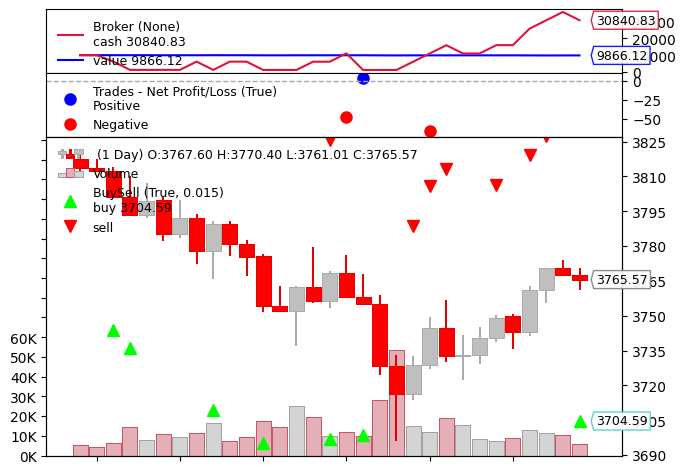

[[<Figure size 640x480 with 4 Axes>]]

In [161]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MAstrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.000)
data = bt.feeds.PandasData(dataname=kline_next_df )
cerebro.adddata(data)
   
print('<START> Brokerage account: $%.2f' % cerebro.broker.getvalue())
cerebro.run()
print('<FINISH> Brokerage account: $%.2f' % cerebro.broker.getvalue())
%matplotlib inline
# Plot the strategy
cerebro.plot(style='candlestick',loc='grey', grid=False, iplot=False) #You can leave inside the paranthesis empty